## Importació de llibreries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Llibreria per manipular dades a través d'una taula
import pandas as pd
import time
from tqdm import tqdm


### Parametrització dels conjunts d'entrenament i test
Inicialitza dataset_dir amb el path del directori RedEdgeCompact

In [2]:
dataset_dir = "RedEdgeCompact/"
# === CONJUNT D'ENTRENAMENT =========================
train_params = dict()
train_params["path"] = dataset_dir
train_params["fields"] = ["000", "001", "002", "004"];
train_params["bands"] = ["R","G","B", "NIR", "RE"]

# === CONJUNT DE TEST ===============================
test_params = dict()
test_params["path"] = dataset_dir
test_params["fields"] = ["003"]
test_params["bands"] = train_params["bands"]

## Classes i funcions per carregar i manipular els datasets

Classe per accedir als retalls d'ortoimatge del dataset de manera indexada. S'obtenen les dades multiespectrals del retall indicat, així com la seva segmentació ground truth (imatge amb 4 bandes, cadascuna amb la máscara binària de cada classe: background, weed, crop, nodata).

In [3]:
class Dataset:
    """ Llegeix imatges, i hi aplica transformacions d'augmentació i preprocés.

    Args:
        dataset: diccionari amb la informació per generar els conjunts d'entrenament
                 a partir de la càrrega d'informació de disc.
        bands: informació espectral a considerar en les imatges
        mode: indica si es vol un dataset que retorni totes les imatges junte ("complete")
              o bé la part a utilitzar en l'entrenament o la validació ("training" "validation")
        augmentation (albumentations.Compose): pipeline de trandformació de les dades
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): pipeline de preprocés de les dades
            (e.g. normalització, canvis en el 'shape', etc.)
    """

    def __init__(
            self,
            dataset,
            bands,
            mode = "complete",
            augmentation=None,
            preprocessing=None,):

        # Init directori structure organizing the weed map dataset
        labels_dir = "groundtruth"
        images_dir = "tile"
        masks_dir = "mask"


        # A partir de la informació del diccionari es defineixen els paths on buscar la informació
        self.images_band_pattern = list()
        self.labels = list()
        self.masks = list()
        for field in dataset["fields"]:

            images_path = os.path.join(dataset["path"], \
                                     field, \
                                     images_dir);

            labels_path = os.path.join(dataset["path"], \
                                     field, \
                                     labels_dir);

            masks_path = os.path.join(dataset["path"], \
                                     field, \
                                     masks_dir);


            # Per cada camp, el nom de les imatge a carregar s'extreun a partir
            # del directori de màscares. Per cada imatge de màscara hi ha d'haver
            # una imatge amb informació espectral corresponent.

            images = sorted([f for f in os.listdir(masks_path) if not f.startswith('.')])

            # Es genera una string de format que s'utilitzarà per després carregar
            # la informació de les bandes de cada imatge

            self.images_band_pattern = self.images_band_pattern +  \
                        [os.path.join(images_path, "{band}", image) \
                          for image in images]

            # Es generen els noms complets per les imatges d'anotació (etiquetes GT)
            self.labels = self.labels + \
                        [os.path.join(labels_path, \
                                      field+'_'+image.replace('.png','_GroundTruth_iMap.png') ) \
                          for image in images]

            # Es generen els noms complets per les imatges de màscara. Indica els píxels
            # pels que es té informació espectral o no (Hi ha zones molt grans de l'ortomapa
            # per les que no es té informació).
            self.masks = self.masks + \
                        [os.path.join(masks_path,image) \
                          for image in images]

        # Depenent del mode seleccionat, l'objecte creat donarà accés a les ades completes o bé a
        # un percentatge d'elles (70% si mode="training", i el 30% complementari si mode="validation")

        if mode in ["training", "validation"]:

            num_images = len(self.images_band_pattern)
            training_percent = 0.7
            # El generador de números aleatoris s'inicialitza a una llavor fixa, per així garantir que les
            # versions "training" i "test" del dataseet són conjunts complementaris.
            np.random.seed(0)
            values = np.random.uniform(size=num_images)

            if mode=="training":
                selected_elements = (values<=training_percent)
            elif mode=="validation":
                selected_elements = (values>training_percent)

            self.images_band_pattern = np.array(self.images_band_pattern)[selected_elements]
            self.labels = np.array(self.labels)[selected_elements]
            self.masks = np.array(self.masks)[selected_elements]

            print("{} dataset preparat: {} de {} imatges seleccionades".format(mode,np.sum(selected_elements),num_images))


        elif mode!="complete":
            print("Mode {} desconegut. Es retorna el conjunt de dades complet")

        # L'anotació GT del weed map dataset distingeix 3 classes.
        # class_codes 0: background, 2: weed, 10000: crop
        # En realitat però n'hi ha 4. La máscara que indica els píxels que
        # tenen dades permet etiquetar doncs els píxels que simplement no tenen
        # dades, als que donarem l'etiqueta de "nodata", mentre en el dataset
        # inicialment els posaven dins la classe "background"

        self.class_names = ["background", "weed", "crop", "nodata"]
        self.num_classes = len(self.class_names)

        self.bands = bands
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i): # Retorna la imatge i la màscara del i-èssim element del dataset.
        # Carrega la informació de les bandes de l'element 'i-èssim' del dataset

        image_band_pattern = self.images_band_pattern[i]
        band_list = []
        for band in self.bands:
            band_filename = image_band_pattern.format(band=band)
            band_image = cv2.imread(band_filename, -cv2.IMREAD_LOAD_GDAL)
            # Els valors dels píxels es normalitzen en el rang [0, 1]
            band_image = band_image/255.0
            band_list.append(band_image)

        image = np.dstack(band_list)

        # codec_labels: Anotació Ground truth de cada píxel de la imatge
        coded_labels = cv2.imread(self.labels[i], -cv2.IMREAD_LOAD_GDAL)

        # Les etiquetes dels píxels d'una imatge s'organitzen en una imatge
        # multicanal, on cada canal és una máscara binaria que indica els
        # píxels que formen part d'una determinada classe.

        # El conjunt de dades "Weedmap" dataset distingeix 3 tipus de píxels
        # a partir de 3 valors indicats a la imatge d'anotació GT, on cada
        # valor denota la següent informació
        # 0: background (inclou també els píxels que no tenen informació espectral
        # 2: weed
        # 10000: crop

        # Es reformata la informació de ground truth, passant de tenir un valor numèric
        # per cada classe a tenir una imatge binària per cada classe. Així, hi ha tantes
        # màscares com classes diferents. Es guarden com a float per requisits de processos
        # posteriors.
        class_codes = [0, 2, 10000]
        masks = [(coded_labels == code) for code in class_codes]
        mask = np.stack(masks, axis=-1).astype('float')

        # Per tractar millor les dades, es diferencia entre pixels 'background' del cultiu
        # i píxels que simplement no tenen informació (pixels en tiles 'fora' de l'ortomapa)
        # Això vol dir que:
        #  Els píxels que no tenen informació espectral es treuen de la màscara background.
        #  Es fa una nova màscara pels píxels que no tenen informació.

        # Es llegeix la màscara que indica quins píxels tenen informació espectral

        nodata_pixel_mask = cv2.imread(self.masks[i], -cv2.IMREAD_LOAD_GDAL).astype('float')/255.0

        # S'ha vist que les imatges de máscara del dataset, en els píxels de les vores de la máscara a vegades
        # indiquen que no hi ha informació en píxels on si hi ha informació, i que formen part de les
        # classes weed i crop. Per tractar aquesta incoherència, es ralitza el següent:
        # - En lloc de corregir la màscara nodata_pixel_mask (donaria força feina), ens asegurem que en
        # els píxels de nodata_pixel_mask la resta de classes no tinguin un valor de '1' en la seva
        # imaatge binària.
        # - Afegim una classe més, que serà la desl píxels sense dades.
        # Resolem la incoherència afegint però una mica de soroll, doncs en píxels on hi ha informació
        # s'indica que la classe a predir és 'nodata', però a nivell percentual això és un número de píxels
        # infim, de manera que d'entrada sembla assumible.

        # Els pixels que segons la máscara no tenen dades no s'els permet ser "background", "weed" o "crop"...
        mask[nodata_pixel_mask==1] = 0;
        # ... si no que formen part d'una nova classe que anomenem "nodata".
        mask = np.dstack((mask,nodata_pixel_mask))

        # Si hi ha un funció de data augmentation, s'aplica tranformant tant la imatge com la màscara.
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Si hi ha una funció de proprocés s'aplica tranformant tant la imatge com la màscara
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):  # Retorna la quantitat d'imatges al dataset
        return len(self.images_band_pattern)

Funció per mostrar per pantalla 'n' imatge rebudes com a paràmetre

In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure()
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Establiment d'una mida de figura major per veure resultats per pantalla.

In [5]:
plt.rcParams['figure.figsize'] = [12, 6]

Exemple d'accés i visualització d'un retall d'ortoimatge

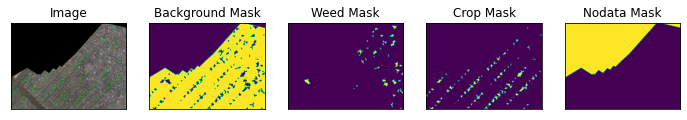

In [6]:
train_dataset = Dataset(train_params, train_params["bands"])
image, mask = train_dataset[1]
visualize(
    image=image[:,:,0:3],
    background_mask=mask[:,:, 0],
    weed_mask = mask[:,:, 1],
    crop_mask = mask[:,:, 2],
    nodata_mask = mask[:,:,3]
)

Funció per mostrar màscares de les classes com imatge a color

Les diferents classes es mostren amb la següent convenció de colors
* bakground: negre
* weed: vermell
* crop: verd
* nodata: blau

In [7]:
def generate_color_mask(mask):
    color_mask = np.zeros((mask.shape[0],mask.shape[1],3))
    color_mask[:,:,0] = mask[:,:,1]
    color_mask[:,:,1] = mask[:,:,2]
    color_mask[:,:,2] = mask[:,:,3]
    return color_mask;

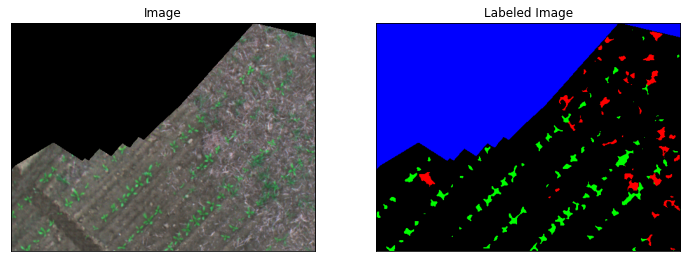

In [8]:
visualize( image=image[:,:,0:3],
           labeled_image=generate_color_mask(mask))

## 1. Anàlisi dels estadístics del dataset
Abans de desenvolupar un sistema de segmentació semàntica cal analitzar les dades de partida: quines bandes hi ha, com es distribueix el valor de cada banda segons la classe de cada píxel, etcètera.

Per facilitar aquest anàlisi, disposes de la següent funció que recull la informació dels píxels d'una quantitat d'imatges indicada en un DataFrame de pandas.

In [9]:
def generate_df_from_dataset(dataset, num_images):
    num_classes = dataset.num_classes;
    class_names = dataset.class_names

    # Es fa una selecció aleatòria d'imatges del dataset per analitzar els estadístics del dataset.dataset
    # Si num_images és igual o major que el número d'imatges al datasets, és posa la informació del dataset
    # sense en el DataFrame
    selected_images = []
    if num_images<len(dataset):
        # S'estableix la llavor de números aleatoris, per obtenir el mateix resultat a cada execució
        np.random.seed(0)
        selected_images = np.random.randint(len(dataset), size=num_images)
    else:
        num_images = len(dataset)
        selected_images = range(len(dataset))

    print("Imatges al dataset:{} - Quantitat d'imatges analitzades aleatòriament:{}".format(len(dataset),num_images))

    # Es crea un diccionari d'arrays buits, per recollir la informació de les bandes de cada píxel, per cada classe.
    # Cada fila dels arrays conté la informació de totes les bandes de cada píxel
    band_values_per_class = dict.fromkeys(np.arange(num_classes),np.empty((0,len(dataset.bands)),dtype='float'))

    start = time.time()
    for i in tqdm(selected_images):

        image, mask = dataset[i]

        for j in range(mask.shape[-1]): # Per cadascuna de les classes anotades
            # Per cada classe es recull la informació dels seus píxels
            band_values_per_class[j] = np.vstack((band_values_per_class[j], image[mask[:,:,j]==1]))

    # La informació delx píxels recollida s'utilitza per inicialitzar un DataFrame de panda
    # per analitzar-lo amb les seves eines d'anàlisi i visualització. Per treure profit
    # del funcionament de panda, s'afegeix una nova columna per cada píxel indicant la
    # classe a la que pertany.

    full_data = np.empty((0,len(dataset.bands)))
    class_name_column = np.empty((0,1))
    class_code_column = np.empty((0,1))
    for i in range(num_classes):
        full_data = np.vstack((full_data, \
                      band_values_per_class[i]))
        num_samples_per_class = band_values_per_class[i].shape[0]

        if num_samples_per_class>0:
            class_name_column = np.vstack((class_name_column, \
                                   [[class_names[i]]]*num_samples_per_class))
            class_code_column = np.vstack((class_code_column,
                                           [[i]]*num_samples_per_class))

    # The DataFrame is created, and an initial "Class" column is added
    df = pd.DataFrame(full_data, columns =dataset.bands)
    df.insert(0, "Class", class_name_column, True)
    df.insert(0, "Class_Code", class_code_column, True)

    end = time.time()
    print(end - start)
    print("Temps transcorregut per carregar les dades:{}".format(end-start))

    return df

El següent codi obté el Dataframe per 'num_imatges' imatges aleatòries dels datasets d'entrenament i test.

In [10]:
num_imatges = 50
train_dataset = Dataset(train_params, train_params["bands"])
train_df = generate_df_from_dataset(train_dataset, num_imatges)

test_dataset = Dataset(test_params, test_params["bands"])
test_df = generate_df_from_dataset(test_dataset, num_imatges)

Imatges al dataset:455 - Quantitat d'imatges analitzades aleatòriament:50


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


17.175897359848022
Temps transcorregut per carregar les dades:17.175897359848022
Imatges al dataset:102 - Quantitat d'imatges analitzades aleatòriament:50


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


16.11233115196228
Temps transcorregut per carregar les dades:16.11233115196228


## 1.1 Anàlisi de la proporció dels píxels de cada classe
Afegeix aquí el teu codi per processar el DataFrames generat a partir del mostreig del datasets. Mostra:
* La quantitat i proporció de píxels de cada classe
* El diagrama circular (pie plot) del dataset

In [18]:
# Completa la següent funció
def analisi_proporcio_classes(df, pie = True):
    total = len(df)
    base = df.groupby('Class').describe()['Class_Code'][['count']]
    base['proportion'] = base['count'] / total
    base['Class'] = base.index.values
    if pie:
        colors = sns.color_palette('pastel')
        explode = [0.03] * len(base)
        fig = plt.figure(figsize = (7,7))#, background = 'white')
        plt.pie(base['count'].values, labels = base.index.values, colors = colors, explode = explode, autopct = '%.0f%%', shadow = True)
    return base

,count,proportion,Class
Class,,,
background,6500162.0,0.752334,background
crop,386874.0,0.044777,crop
nodata,1522938.0,0.176266,nodata
weed,230026.0,0.026623,weed


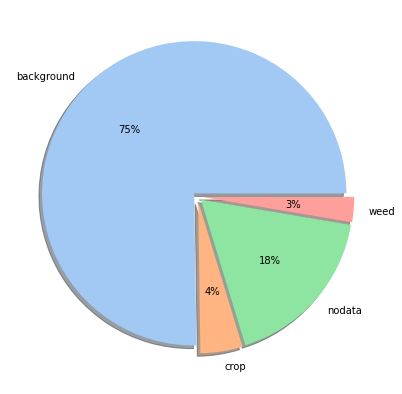

In [19]:
analisi_proporcio_classes(train_df, pie = True)

,count,proportion,Class
Class,,,
background,5923247.0,0.685561,background
crop,361999.0,0.041898,crop
nodata,2273349.0,0.263119,nodata
weed,81405.0,0.009422,weed


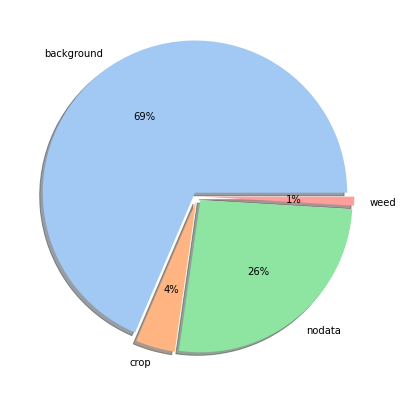

In [20]:
analisi_proporcio_classes(test_df, pie = True)

Repeteix l'anàlisi eliminant els píxels de tipus 'nodata' dels dataframes. No cal considerar aquests tipus de píxels perquè ja coneixem la seva classe a priori (el programa de generació de les ortoimatges ja ens dona la seva màscara). Per altra banda, la seva classificació és trivial (corresponen a píxels amb valor zero a totes les seves bandes)

,count,proportion,Class
Class,,,
crop,386874.0,0.180796,crop
nodata,1522938.0,0.711707,nodata
weed,230026.0,0.107497,weed


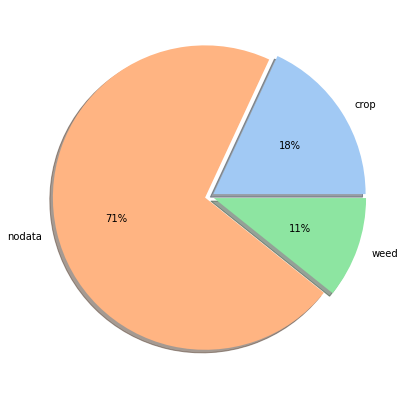

In [21]:
analisi_proporcio_classes(train_df[train_df['Class'] != 'background'], pie = True)

,count,proportion,Class
Class,,,
crop,361999.0,0.133247,crop
nodata,2273349.0,0.836789,nodata
weed,81405.0,0.029964,weed


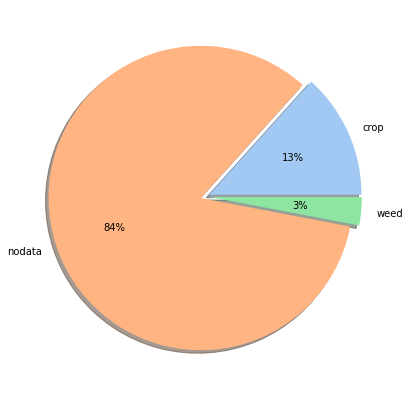

In [22]:
analisi_proporcio_classes(test_df[test_df['Class'] != 'background'],pie = True)

## 1.2 Anàlisi de l’histograma dels píxels de cada cada classe
Per analitzar si els diferents tipus de píxels són discriminable a partir d’una sola banda, a continuació visualitza el solapament dels seus histogrames a cada banda. Per realitzar aquest estudi, els bins a considerar en els histrogrames s’estableixen a continuació.

In [16]:
bins = (np.arange(0,255)-0.5)/255.0

## 2 Segmentació semàntica basada en la informació d'un píxel

Analitza el rendiment de diferents classificadors 'clàssics' per discriminar entre píxels 'background', 'weed' i 'crop'.
* Prova diferents alternatives (a la llibreria scikit-learn trobaràs múltiples algoritmes ja implementats, i fàcils de fer anar).
* Identifica els algoritmes que van millor, i mira de millorar-ne el rendiment a partir d'ajustar els seus paràmetres.
* A banda de les mètriques disponibles a scikit-learn, implementa les mètriques específiques per semantic segmentation que es comenten a l'enunciat de la pràctica.

El següent codi extreu dels DataFrames els valors de 'x' (dades) i 'y' (etiqueta ground truth) que s'utilitzen a les funcions de scikit-learn per entrenar i avaluar classificadors (funcions fit, predict, classification_report, ...

Es fa un mostreig de les dades disponible. En funció de les capacitats del teu ordinador pots augmentar o disminuir el valor de 'num_samples'

In [17]:
num_samples = 5000
sampled_train_df = train_df.sample(num_samples,random_state=0)
sampled_test_df = test_df.sample(num_samples,random_state=0)

selected_bands = train_params["bands"]
x_train = sampled_train_df[selected_bands].to_numpy()
y_train = sampled_train_df["Class_Code"].to_numpy()
x_test = sampled_train_df[selected_bands].to_numpy()
y_test = sampled_train_df["Class_Code"].to_numpy()

## 3 Anàlisi del rendiment a nivell d'imatge
Per tenir una visió qualitativa del millor mètode identificat a la secció anterior, implementa una funció per aplicar-lo a tots els píxels d'una imatge del dataset, per obtenir la seva segmentació semàntica resultant.

Utilitza les mètriques treballades a la secció anterior per identificar les 5 imatges del test_dataset on el classificador funciona millor, i les 5 imatges on el classificador funciona pitjor.